In [33]:
import pandas as pd 
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
df_train = pd.read_csv('optiver-trading-at-the-close/train.csv')
df_train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


<Axes: title={'center': 'Stock 0 on Day 0 - How the order book pricing changes during the auction'}, xlabel='seconds_in_bucket'>

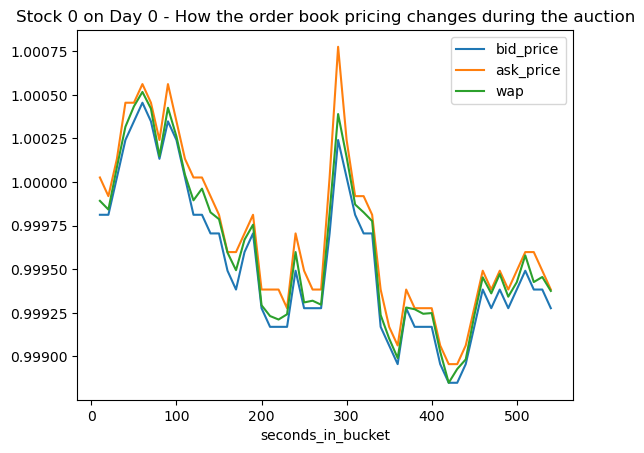

In [34]:
(
    train
    .query('stock_id ==0 & date_id ==0')
    [['seconds_in_bucket','bid_price','ask_price', 'wap']]
    .replace(0, np.nan)
    .set_index('seconds_in_bucket')
    .plot(title='Stock 0 on Day 0 - How the order book pricing changes during the auction')
)

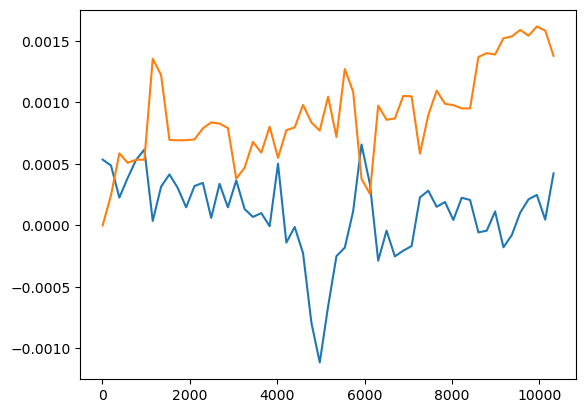

In [35]:
s = train.query('stock_id==10 & date_id==0')
fig,ax = plt.subplots()

ax.plot(s.index,s['target']/10000)
ax.plot(s.index,s['wap']-1)

<Axes: title={'center': 'Stock 0 on Day 0 - How the auction & combined book pricing changes during the auction'}, xlabel='seconds_in_bucket'>

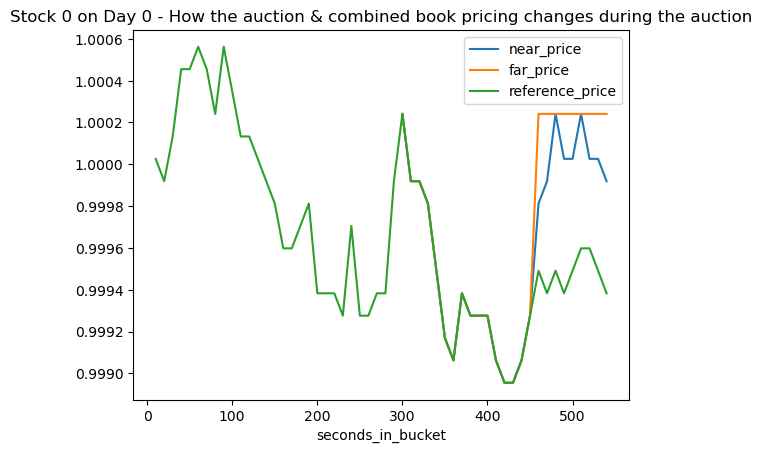

In [36]:
(
    train
    .query('stock_id ==0 & date_id ==0')
    [['seconds_in_bucket','near_price','far_price','reference_price']]
    .replace(0, np.nan)
    .set_index('seconds_in_bucket')
    .plot(title = 'Stock 0 on Day 0 - How the auction & combined book pricing changes during the auction')
)

<Axes: title={'center': 'Stock 0 on Day 0 - How the auction sizing changes during the auction period'}, xlabel='seconds_in_bucket'>

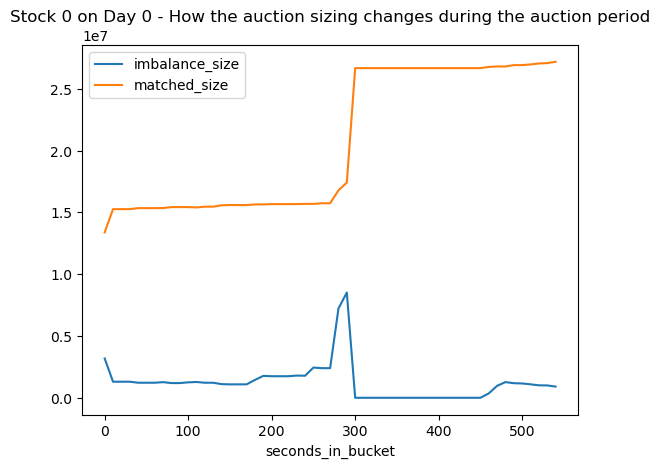

In [37]:
(
    train
    .query('stock_id ==0 & date_id ==0')
    [['seconds_in_bucket','imbalance_size','matched_size']]
    .set_index('seconds_in_bucket')
    .plot(title='Stock 0 on Day 0 - How the auction sizing changes during the auction period')
)

In [38]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)



df_train = df_train.drop(["far_price", "near_price", "row_id", "time_id"], axis=1)
df_train = df_train.dropna()

df_train.index = list(range(len(df_train)))

y_train = df_train["target"]
X_train = df_train.drop(["target"], axis=1)

X_tr = X_train[:-3*55*200]
X_va = X_train[-3*55*200:]
y_tr = y_train[:-3*55*200]
y_va = y_train[-3*55*200:]

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'n_estimators': 100000
}

model = lgb.LGBMRegressor(**params)
model.fit(
    X_tr,
    y_tr,
    eval_set=[(X_tr, y_tr), (X_va, y_va)],
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True), lgb.log_evaluation(10)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 5204760, number of used features: 12
[LightGBM] [Info] Start training from score -0.047946
Training until validation scores don't improve for 100 rounds
[10]	training's l1: 6.35657	valid_1's l1: 5.24428
[20]	training's l1: 6.34292	valid_1's l1: 5.23995
[30]	training's l1: 6.33357	valid_1's l1: 5.23806
[40]	training's l1: 6.32688	valid_1's l1: 5.24331
[50]	training's l1: 6.32221	valid_1's l1: 5.24463
[60]	training's l1: 6.31793	valid_1's l1: 5.24887
[70]	training's l1: 6.31419	valid_1's l1: 5.25157
[80]	training's l1: 6.31104	valid_1's l1: 5.25118
[90]	training's l1: 6.30864	valid_1's l1: 5.25448
[100]	training's l1: 6.30601	valid_1's l1: 5.25854
[110]	training's l1: 6.3036	

LGBMRegressor(metric='mae', n_estimators=100000, objective='regression')

In [42]:
X_tr

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999812,60651.50,1.000026,8493.03,1.000000
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.999896,3233.04,1.000660,20605.09,1.000000
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.999403,37956.00,1.000298,18995.00,1.000000
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.999999,2324.90,1.000214,479032.40,1.000000
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.999394,16485.54,1.000016,434.10,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
5204755,195,477,540,2809393.38,-1,1.002359,35296955.75,1.002359,424927.60,1.002482,326361.57,1.002429
5204756,196,477,540,1236161.74,-1,0.998663,8814158.85,0.998663,36276.52,0.999168,95031.58,0.998803
5204757,197,477,540,509422.85,1,0.997623,10364257.03,0.997240,20846.00,0.997623,27527.28,0.997405
5204758,198,477,540,5724317.95,-1,0.999832,63738563.90,0.999712,538354.70,0.999952,967689.35,0.999797


In [49]:
df_test = pd.read_csv('optiver-trading-at-the-close/example_test_files/test.csv')
test = df_test.drop(["far_price", "near_price", "row_id", "time_id",'currently_scored'], axis=1).fillna(0)
test['predictions'] = model.predict(test)


In [50]:


actual = pd.read_csv('optiver-trading-at-the-close/example_test_files/revealed_targets.csv').dropna()
LGB_dec_tree_mae = (actual['revealed_target']-test['predictions']).abs().mean()
print(f"MAE for Gradient Boosting Decision Tree = {LGB_dec_tree_mae}")

MAE for Gradient Boosting Decision Tree = 5.458742633757269
